In [1]:
# PTB-XL xLSTM Model
import os
import ast
import wfdb
import torch
import zipfile
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from tqdm import tqdm
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc

In [2]:
# --- Dataset Preparation ---
dataset_path = Path("data/raw/ptbxl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1")
ptbxl_path = dataset_path / "ptbxl_database.csv"
waveform_path = dataset_path

df = pd.read_csv(ptbxl_path)
df['scp_codes'] = df['scp_codes'].apply(ast.literal_eval)
df['scp_keys'] = df['scp_codes'].apply(lambda x: list(x.keys()))
target_labels = ['NORM', 'SR', 'AFIB', 'PVC', 'LVH', 'ABQRS', 'IMI', 'ASMI', 'LAFB', 'IRBBB']
df['scp_filtered'] = df['scp_keys'].apply(lambda x: [k for k in x if k in target_labels])
df = df[df['scp_filtered'].map(len) > 0]
mlb = MultiLabelBinarizer(classes=target_labels)
y = mlb.fit_transform(df['scp_filtered'])
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=42)


def load_ecg(record_path):
    record = wfdb.rdrecord(record_path)
    return record.p_signal


class PTBXL_Dataset(Dataset):
    def __init__(self, df, labels, base_dir):
        self.df = df
        self.labels = labels
        self.base_dir = base_dir

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        full_path = os.path.join(self.base_dir, row['filename_lr'])
        signal = load_ecg(full_path).T  # [12, 5000]
        return torch.tensor(signal, dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.float32)


train_dataset = PTBXL_Dataset(X_train, y_train, waveform_path)
test_dataset = PTBXL_Dataset(X_test, y_test, waveform_path)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=8, num_workers=2, pin_memory=True)

In [3]:
# --- xLSTM Model ---
class xLSTMECG(nn.Module):
    def __init__(self, input_channels=12, num_classes=10, hidden_size=128, num_layers=2):
        super().__init__()
        self.conv1 = nn.Conv1d(input_channels, 32, kernel_size=7, padding=3)
        self.bn1 = nn.BatchNorm1d(32)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv1d(32, 64, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(64)

        self.lstm = nn.LSTM(input_size=64, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = x.permute(0, 2, 1)  # [B, T, C]
        x, _ = self.lstm(x)
        x = x[:, -1, :]  # last time step
        return self.fc(x)

In [4]:
# --- Training & Evaluation ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = xLSTMECG(input_channels=12, num_classes=len(target_labels)).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 10
losses, accuracies = [], []
for epoch in range(epochs):
    model.train()
    total_loss, correct, total = 0, 0, 0
    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
    for signals, labels in train_loader_tqdm:
        signals, labels = signals.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(signals)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        preds = (torch.sigmoid(outputs) > 0.5).float()
        acc = (preds == labels).float().mean().item()
        correct += acc
        total += 1
        train_loader_tqdm.set_postfix(loss=loss.item())
    losses.append(total_loss / len(train_loader))
    accuracies.append(correct / total)
    print(f"Epoch {epoch+1}, Avg Loss: {losses[-1]:.4f}, Avg Accuracy: {accuracies[-1]:.4f}")


Epoch 1/10: 100%|██████████| 2094/2094 [01:06<00:00, 31.65it/s, loss=0.266]


Epoch 1, Avg Loss: 0.3634, Avg Accuracy: 0.8613


Epoch 2/10: 100%|██████████| 2094/2094 [01:06<00:00, 31.72it/s, loss=0.317] 


Epoch 2, Avg Loss: 0.3159, Avg Accuracy: 0.8793


Epoch 3/10: 100%|██████████| 2094/2094 [01:05<00:00, 32.00it/s, loss=0.308] 


Epoch 3, Avg Loss: 0.2903, Avg Accuracy: 0.8864


Epoch 4/10: 100%|██████████| 2094/2094 [01:05<00:00, 31.79it/s, loss=0.298] 


Epoch 4, Avg Loss: 0.2633, Avg Accuracy: 0.8950


Epoch 5/10: 100%|██████████| 2094/2094 [01:05<00:00, 31.75it/s, loss=0.188] 


Epoch 5, Avg Loss: 0.2426, Avg Accuracy: 0.9027


Epoch 6/10: 100%|██████████| 2094/2094 [01:05<00:00, 31.83it/s, loss=0.216] 


Epoch 6, Avg Loss: 0.2196, Avg Accuracy: 0.9119


Epoch 7/10: 100%|██████████| 2094/2094 [01:05<00:00, 32.05it/s, loss=0.222] 


Epoch 7, Avg Loss: 0.2034, Avg Accuracy: 0.9199


Epoch 8/10: 100%|██████████| 2094/2094 [01:05<00:00, 31.90it/s, loss=0.156] 


Epoch 8, Avg Loss: 0.1936, Avg Accuracy: 0.9239


Epoch 9/10: 100%|██████████| 2094/2094 [01:05<00:00, 32.07it/s, loss=0.141] 


Epoch 9, Avg Loss: 0.1873, Avg Accuracy: 0.9257


Epoch 10/10: 100%|██████████| 2094/2094 [01:05<00:00, 31.87it/s, loss=0.145] 

Epoch 10, Avg Loss: 0.1813, Avg Accuracy: 0.9286


In [5]:
# --- Evaluation ---
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for signals, labels in test_loader:
        signals, labels = signals.to(device), labels.to(device)
        outputs = model(signals)
        y_true.append(labels.cpu().numpy())
        y_pred.append(torch.sigmoid(outputs).cpu().numpy())

y_true = np.vstack(y_true)
y_pred = np.vstack(y_pred)

print("Classification Report:")
print(classification_report(y_true > 0.5, y_pred > 0.5, target_names=mlb.classes_))
print("Macro ROC-AUC:", roc_auc_score(y_true, y_pred, average='macro'))

Classification Report:
              precision    recall  f1-score   support

        NORM       0.86      0.88      0.87      1931
          SR       0.89      0.95      0.92      3361
        AFIB       0.72      0.93      0.81       297
         PVC       0.81      0.61      0.69       228
         LVH       0.65      0.68      0.66       409
       ABQRS       0.74      0.54      0.62       711
         IMI       0.70      0.53      0.61       565
        ASMI       0.90      0.48      0.63       452
        LAFB       0.74      0.70      0.72       314
       IRBBB       0.55      0.44      0.49       224

   micro avg       0.83      0.80      0.81      8492
   macro avg       0.76      0.68      0.70      8492
weighted avg       0.82      0.80      0.81      8492
 samples avg       0.82      0.83      0.80      8492

Macro ROC-AUC: 0.9334624521858779


/users/PLS0151/nicholaskanos/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


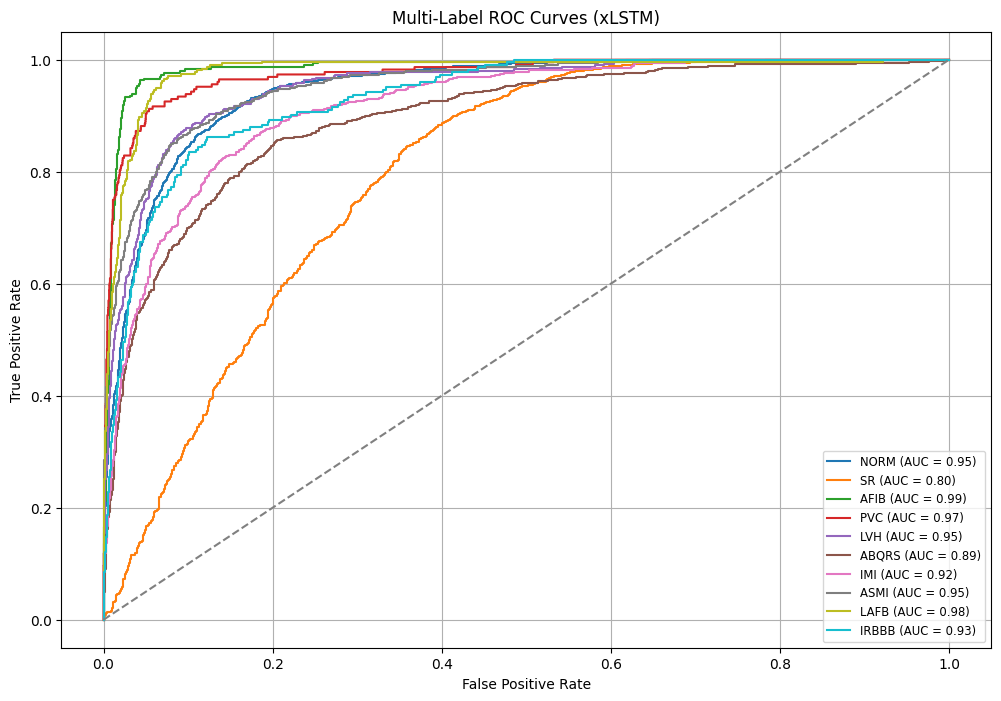

In [6]:
# --- ROC Curves ---
plt.figure(figsize=(12, 8))
for i, label in enumerate(mlb.classes_):
    fpr, tpr, _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Label ROC Curves (xLSTM)')
plt.legend(loc='lower right', fontsize='small')
plt.grid(True)
plt.show()